# Classifying climate related sentences

In this project I attempt to determine to what extent British newspapers misreport information about climate change. To do so I implement the following steps:
- Manually classify a set of news articles at the sentence level
- Use this set to fine-tune the pre-trained Bert model
- Use the fine-tuned model to predict classes for the remaining articles

## The sample for training

After scraping from Nexis the universe of British news articles that contain either "*climate change*" or "*global warming*", I first divided the sample into topics using LDA (code not reported here). The rationale is simple: *climate change* or *global warming* appear in a wide variety of contexts, e.g. when reporting about floods, hurricanes, or when reporting about current energy policy issues or also when reporting simply about politics, as the issue is often mentioned in political agendas. Therefore I want to manually classify articles not just randomly from the whole sample, but randomizing within topics, according to the weight each topic has in the sample. A concrete example: a topic which I labeled "Extreme weather events" accounts for $12\%$ of all the articles. Therefore if I want to classify manually $100$ articles, $12$ of them will be randomly selected from this topic.



In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
np.random.seed(1337)
import datetime
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.models import Model
import datetime
import matplotlib.pyplot as plt


In [2]:
# Import manually classified sample
dir = "/mypath/"
df_to_use = pd.read_excel(dir+"sample_manual2.xlsx", engine='openpyxl', sheet_name="Sheet1")

In the dataset articles are split into sentences, which are then manually classified as follows:
- if sentence is aligned with scientific consensus on climate change: 1
- if sentence is not aligned with scientific consensus on climate change: -1
- if sentence is not at all related with climate science: 2

Being *aligned with scientific consensus* means reporting facts discovered by the scientific community. Here are some examples:

In [11]:
df_to_use['Transcript'][df_to_use['Score']==1].head(5)

0     This enabled the BBC yet again to claim that A...
26     The onset of global warming poses real concer...
27     If gales, floods and droughts are to become m...
28     According to an ABI report published last mon...
31     By the 2050s, East Anglia's coastline is expe...
Name: Transcript, dtype: object

Instead, sentences labelled with $-1$ are generally those that:
- negate statements made by climate scientists
- report climate science as unsettled, i.e. as if there is an ongoing debate
- use ironic language to refer to climate scientists

See here some examples:

In [12]:
df_to_use['Transcript'][df_to_use['Score']==-1].tail(5)

38987    Global temperatures stopped rising 15 years ag...
38988    Needless to add, support of global warming ala...
38989    Why should we believe what the IPCC predicts, ...
38990    Recent global warming has actually helped to r...
38991    The more CO2 there is in the air, the better p...
Name: Transcript, dtype: object

Let's look quickly at what this sample looks like:

In [13]:
# How many 1s, -1s and 2s are in the sample?
df_to_use['Score'].value_counts()


 2    33988
 1     4442
-1      562
Name: Score, dtype: int64

In [15]:
# Since the sample is highly unbalanced we can get rid of some sentences not related to climate science
# Even a smaller number should be enough
aux = df_to_use.loc[df_to_use['Score']==2] # Keep only the 2s
aux = aux.sample(n=6000, random_state = 4) # 6000 should be enough
aux2 = df_to_use.loc[df_to_use['Score']!=2]
df_to_use = aux.append(aux2)               # Rebuild the dataset for use
df_to_use['Score'].value_counts()          # Re-check how many sentences we have now

 2    6000
 1    4442
-1     562
Name: Score, dtype: int64

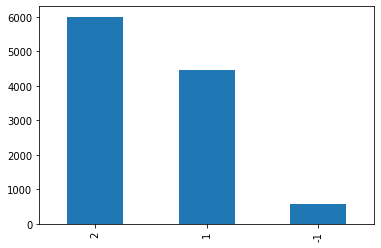

In [16]:
# Let's just keep the columns of interest
train_raw = df_to_use[['Transcript','Score']]

# See the distribution of the labels
train_raw['Score'].value_counts().sort_values(ascending=False).plot(kind='bar')


In [17]:
# Rename the columns
train_raw=train_raw.rename(columns = {'Transcript':'text', 'Score':'label'})
train_raw.head()

,text,label
30828,As we approach World Food Day this ­coming Mo...,2
23303,We can do something as a government,2
32494,The results reveal that Scandinavian countrie...,2
28201,If there were any doubts about the Coalition'...,2
37664,But the Prime Minister has been hit by a back...,2


In [18]:
from sklearn.preprocessing import LabelEncoder

# Let's relabel the labels
LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])

# Make taining set copy
train = train_raw.copy()

In [20]:
# Clean the text column a bit
import re

def clean_txt(text):
    text = re.sub("'","",text)
    text = re.sub("(\\W)+"," ",text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'\s*(?:[\w_]*_(?:[\w_]*_)*[\w_]*)', '', text)
    text = re.sub(r'\s*(?:[\w_]*[0-9+](?:[\w_]*[0-9+])*[\w_]*)', '', text)
    text = text.lower()
    return text

train['text'] = train.text.apply(clean_txt)
train.head()

,text,label
30828,as we approach world food day this coming mon...,2
23303,we can do something as government,2
32494,the results reveal that scandinavian countrie...,2
28201,if there were any doubts about the coalitions...,2
37664,but the prime minister has been hit by backla...,2


In [21]:
# Create training and validation sets (80/20 proportion)
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)

# Re-index the datasets
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [22]:
# Import necessary libraries
import bert
from bert import run_classifier

In [23]:
### Setting now the output directory for BERT

# Set the output directory for saving model file
OUTPUT_DIR = './bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: ./bert_news_category *****


In [24]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list # now -1 has become 0

[0, 1, 2]

As BERT cannot handle text longer than 250 tokens, we must define a funcion in case the text exceeds this limit.

In [25]:
### Splitting the Data into smaller chunks
# If a text is longer than 250 words, it will be split in 200 words chunks with 50 words overlap

def get_split(text1):
  l_total = []
  l_parcial = []
  # // (floor division) divides and returns the integer value of the quotient
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total


In [26]:
# Apply the split to our training and validation datasets
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head(2)


,text,label,text_split
0,this will be the first time weve actually eli...,1,[this will be the first time weve actually eli...
1,thousands of homes across the uk are without ...,2,[thousands of homes across the uk are without ...


In [27]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,there is overwhelming evidence that habitat l...,1,[there is overwhelming evidence that habitat l...
1,though scientists have studied this behaviour...,2,[though scientists have studied this behaviour...


In [28]:
### Adjust the labels in case of split text
# For training set
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)


(8804, 8804, 8804)

In [29]:
# For validation set
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(2201, 2201, 2201)

In [31]:
# The final dataset for training
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df['label'].value_counts()

2    4805
1    3549
0     450
Name: label, dtype: int64

In [32]:
# The final dataset for validation
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df['label'].value_counts()

2    1196
1     893
0     112
Name: label, dtype: int64

In [33]:
## BERT: Data Preprocessing

# Process the data for BERT
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)


In [34]:
## BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)


tokenizer = create_tokenizer_from_hub_module()
# Here you may get an error and may have to execute in the terminal 'rm -rf path-to-folder'
# (this removes the 'incriminated folder')
# Then re-run here

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [35]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))


['this', 'will', 'be', 'the', 'first', 'time', 'we', '##ve', 'actually', 'eliminated', 'an', 'entire', 'ecosystem']


In [36]:
# Convert our train and validation features to InputFeatures that BERT understands.
MAX_SEQ_LENGTH = 200

train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 8804


INFO:tensorflow:Writing example 0 of 8804


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this will be the first time we ##ve actually eliminated an entire ecosystem [SEP]


INFO:tensorflow:tokens: [CLS] this will be the first time we ##ve actually eliminated an entire ecosystem [SEP]


INFO:tensorflow:input_ids: 101 2023 2097 2022 1996 2034 2051 2057 3726 2941 5892 2019 2972 16927 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2023 2097 2022 1996 2034 2051 2057 3726 2941 5892 2019 2972 16927 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] thousands of homes across the uk are without power and many roads are still imp ##ass ##able as britain continues to shiver [SEP]


INFO:tensorflow:tokens: [CLS] thousands of homes across the uk are without power and many roads are still imp ##ass ##able as britain continues to shiver [SEP]


INFO:tensorflow:input_ids: 101 5190 1997 5014 2408 1996 2866 2024 2302 2373 1998 2116 4925 2024 2145 17727 12054 3085 2004 3725 4247 2000 13277 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5190 1997 5014 2408 1996 2866 2024 2302 2373 1998 2116 4925 2024 2145 17727 12054 3085 2004 3725 4247 2000 13277 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] climate talks in paris this month are our last chance to turn the tide [SEP]


INFO:tensorflow:tokens: [CLS] climate talks in paris this month are our last chance to turn the tide [SEP]


INFO:tensorflow:input_ids: 101 4785 7566 1999 3000 2023 3204 2024 2256 2197 3382 2000 2735 1996 10401 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4785 7566 1999 3000 2023 3204 2024 2256 2197 3382 2000 2735 1996 10401 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] if so global warming may have started just in time [SEP]


INFO:tensorflow:tokens: [CLS] if so global warming may have started just in time [SEP]


INFO:tensorflow:input_ids: 101 2065 2061 3795 12959 2089 2031 2318 2074 1999 2051 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2065 2061 3795 12959 2089 2031 2318 2074 1999 2051 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] it also looks beyond the kyoto commitment period of and uses the domestic goal as the spur for further action to cut emissions that will set britain on what is regarded as more sustainable path by encouraging move to less carbon dependent economy [SEP]


INFO:tensorflow:tokens: [CLS] it also looks beyond the kyoto commitment period of and uses the domestic goal as the spur for further action to cut emissions that will set britain on what is regarded as more sustainable path by encouraging move to less carbon dependent economy [SEP]


INFO:tensorflow:input_ids: 101 2009 2036 3504 3458 1996 15008 8426 2558 1997 1998 3594 1996 4968 3125 2004 1996 12996 2005 2582 2895 2000 3013 11768 2008 2097 2275 3725 2006 2054 2003 5240 2004 2062 9084 4130 2011 11434 2693 2000 2625 6351 7790 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2009 2036 3504 3458 1996 15008 8426 2558 1997 1998 3594 1996 4968 3125 2004 1996 12996 2005 2582 2895 2000 3013 11768 2008 2097 2275 3725 2006 2054 2003 5240 2004 2062 9084 4130 2011 11434 2693 2000 2625 6351 7790 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 2201


INFO:tensorflow:Writing example 0 of 2201


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] there is overwhelming evidence that habitat loss and fragmentation over exploitation of biological resources pollution species invasions and climate change have increased rates of global species extinction ##s to levels that are much higher than those observed in the fossil record [SEP]


INFO:tensorflow:tokens: [CLS] there is overwhelming evidence that habitat loss and fragmentation over exploitation of biological resources pollution species invasions and climate change have increased rates of global species extinction ##s to levels that are much higher than those observed in the fossil record [SEP]


INFO:tensorflow:input_ids: 101 2045 2003 10827 3350 2008 6552 3279 1998 28424 2058 14427 1997 6897 4219 10796 2427 23536 1998 4785 2689 2031 3445 6165 1997 3795 2427 14446 2015 2000 3798 2008 2024 2172 3020 2084 2216 5159 1999 1996 10725 2501 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2045 2003 10827 3350 2008 6552 3279 1998 28424 2058 14427 1997 6897 4219 10796 2427 23536 1998 4785 2689 2031 3445 6165 1997 3795 2427 14446 2015 2000 3798 2008 2024 2172 3020 2084 2216 5159 1999 1996 10725 2501 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] though scientists have studied this behaviour since the seeing it first hand was dramatic experience for the researchers [SEP]


INFO:tensorflow:tokens: [CLS] though scientists have studied this behaviour since the seeing it first hand was dramatic experience for the researchers [SEP]


INFO:tensorflow:input_ids: 101 2295 6529 2031 3273 2023 9164 2144 1996 3773 2009 2034 2192 2001 6918 3325 2005 1996 6950 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2295 6529 2031 3273 2023 9164 2144 1996 3773 2009 2034 2192 2001 6918 3325 2005 1996 6950 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] some time ago gps told the minister that there was crisis in general practice [SEP]


INFO:tensorflow:tokens: [CLS] some time ago gps told the minister that there was crisis in general practice [SEP]


INFO:tensorflow:input_ids: 101 2070 2051 3283 14658 2409 1996 2704 2008 2045 2001 5325 1999 2236 3218 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2070 2051 3283 14658 2409 1996 2704 2008 2045 2001 5325 1999 2236 3218 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] browne first joined the company in as an apprentice and worked his way up taking the top job in [SEP]


INFO:tensorflow:tokens: [CLS] browne first joined the company in as an apprentice and worked his way up taking the top job in [SEP]


INFO:tensorflow:input_ids: 101 15005 2034 2587 1996 2194 1999 2004 2019 13357 1998 2499 2010 2126 2039 2635 1996 2327 3105 1999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 15005 2034 2587 1996 2194 1999 2004 2019 13357 1998 2499 2010 2126 2039 2635 1996 2327 3105 1999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] and majority per cent said the us should join other countries in setting standards to address global climate change [SEP]


INFO:tensorflow:tokens: [CLS] and majority per cent said the us should join other countries in setting standards to address global climate change [SEP]


INFO:tensorflow:input_ids: 101 1998 3484 2566 9358 2056 1996 2149 2323 3693 2060 3032 1999 4292 4781 2000 4769 3795 4785 2689 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1998 3484 2566 9358 2056 1996 2149 2323 3693 2060 3032 1999 4292 4781 2000 4769 3795 4785 2689 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [37]:
## BERT: Creating A Multi-Class Classifier Model
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [38]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [39]:
# Specify the size of the batches, the learning rate and the number of epochs
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

num_train_steps, len(label_list)

(550, 3)

In [40]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': './bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x150d9ed90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x150d9ed90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [41]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [45]:
### BERT: Fine Tuning Training & Evaluating ###
from datetime import datetime

#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/Users/magreco/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./bert_news_category/model.ckpt.


INFO:tensorflow:loss = 1.4090145, step = 1


INFO:tensorflow:loss = 1.4090145, step = 1


INFO:tensorflow:global_step/sec: 0.101758


INFO:tensorflow:global_step/sec: 0.101758


INFO:tensorflow:loss = 0.4747469, step = 101 (982.755 sec)


INFO:tensorflow:loss = 0.4747469, step = 101 (982.755 sec)


INFO:tensorflow:global_step/sec: 0.103997


INFO:tensorflow:global_step/sec: 0.103997


INFO:tensorflow:loss = 0.3452792, step = 201 (961.569 sec)


INFO:tensorflow:loss = 0.3452792, step = 201 (961.569 sec)


INFO:tensorflow:Saving checkpoints for 300 into ./bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into ./bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 0.103342


INFO:tensorflow:global_step/sec: 0.103342


INFO:tensorflow:loss = 0.74722993, step = 301 (967.638 sec)


INFO:tensorflow:loss = 0.74722993, step = 301 (967.638 sec)


INFO:tensorflow:global_step/sec: 0.104478


INFO:tensorflow:global_step/sec: 0.104478


INFO:tensorflow:loss = 0.38982016, step = 401 (957.167 sec)


INFO:tensorflow:loss = 0.38982016, step = 401 (957.167 sec)


INFO:tensorflow:global_step/sec: 0.106544


INFO:tensorflow:global_step/sec: 0.106544


INFO:tensorflow:loss = 0.56318367, step = 501 (938.549 sec)


INFO:tensorflow:loss = 0.56318367, step = 501 (938.549 sec)


INFO:tensorflow:Saving checkpoints for 550 into ./bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 550 into ./bert_news_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.27117813.


INFO:tensorflow:Loss for final step: 0.27117813.


Training took time  1:28:38.635908


In [46]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/Users/magreco/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-05-02T19:33:47Z


INFO:tensorflow:Starting evaluation at 2021-05-02T19:33:47Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-550


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-550


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-05-02-19:41:12


INFO:tensorflow:Finished evaluation at 2021-05-02-19:41:12


INFO:tensorflow:Saving dict for global step 550: eval_accuracy = 0.84416175, false_negatives = 33.0, false_positives = 63.0, global_step = 550, loss = 0.3891341, true_negatives = 49.0, true_positives = 2056.0


INFO:tensorflow:Saving dict for global step 550: eval_accuracy = 0.84416175, false_negatives = 33.0, false_positives = 63.0, global_step = 550, loss = 0.3891341, true_negatives = 49.0, true_positives = 2056.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 550: ./bert_news_category/model.ckpt-550


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 550: ./bert_news_category/model.ckpt-550


{'eval_accuracy': 0.84416175,
 'false_negatives': 33.0,
 'false_positives': 63.0,
 'loss': 0.3891341,
 'true_negatives': 49.0,
 'true_positives': 2056.0,
 'global_step': 550}

In [47]:
###################################################################
## BERT: Get The Vector Transformations from the Fine Tuned BERT ##
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])
    
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [48]:
# Now extracting the representations [this takes a while on the unlabelled data]
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))


Now we are going to build a simple LSTM model having as input the vectors created before.

In [49]:
# Make the dataset for train and val:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.21529175, -0.7394364, -0.9999315, -0.40832...",1
1,"[[0.081997536, -0.70977426, -0.99962044, -0.21...",2
2,"[[-0.31381616, -0.7888122, -0.99862915, -0.038...",1
3,"[[-0.9431985, 0.14621414, 0.999251, 0.32380208...",0
4,"[[0.10378519, -0.69067234, -0.9997664, -0.4719...",1


In [50]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()


,emb,label
0,"[[-0.39435336, -0.3823846, -0.689411, -0.53040...",1
1,"[[-0.4020894, -0.6304336, -0.99605834, 0.47824...",2
2,"[[0.8609046, -0.47107053, -0.900671, -0.425417...",2
3,"[[0.9055058, -0.41222087, -0.710509, -0.607144...",2
4,"[[-0.14163546, -0.46758294, -0.98741376, -0.45...",1


In [51]:
# Let's keep part of the validation set for testing
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

In [53]:
### LSTM: Creating the Final Model ###

from keras import layers
from keras.layers import Input

text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 93        
Total params: 350,723
Trainable params: 350,723
Non-trainable params: 0
_________________________________________________________________


Remember that when using a generator to train the model you have to fix the batch size and batches per epoch in order to guarantee that all of your data is passing in your training process. 

The following equation must hold:

$length\ of\ data\ =\ number\ of\ batches\ \times\ batches\ per\ epoch$

In [55]:
# Length of training data
num_sequences = len(df_train['emb'].to_list())
num_sequences

8803

In [56]:
# Since this is a prime number (how lucky!), we remove one row
df_train = df_train.iloc[1:]
num_sequences = len(df_train['emb'].to_list())
num_sequences

8802

In [67]:
# Now we can determine the batch size and therefore the batches per epoch
batch_size = 18
batches_per_epoch =  489
num_features= 768

# Here's the generator function
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train 
            

In [58]:
# Length of validation data
num_sequences_val = len(df_val['emb'].to_list())
num_sequences_val

1320

In [68]:
# Now we can determine the batch size and therefore the batches per epoch
batch_size_val = 15
batches_per_epoch_val = 88
num_features= 768


# Here's the generator function
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

Finally we can train the model, using the Kera’s callback named ReduceLROnPlateau which reduces the hyperparameter learning rate if the validation’s accuaracy does not improve over epochs.

In [69]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [70]:
# Train the model
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
489/489 [==============================] - 2s 3ms/step - loss: 0.2613 - acc: 0.9032 - val_loss: 0.2982 - val_acc: 0.8386
Epoch 2/10
489/489 [==============================] - 2s 3ms/step - loss: 0.2592 - acc: 0.9033 - val_loss: 0.2835 - val_acc: 0.8386
Epoch 3/10
489/489 [==============================] - 1s 3ms/step - loss: 0.2582 - acc: 0.9040 - val_loss: 0.2921 - val_acc: 0.8394
Epoch 4/10
489/489 [==============================] - 2s 3ms/step - loss: 0.2574 - acc: 0.9042 - val_loss: 0.2740 - val_acc: 0.8356

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0008145062311086804.
Epoch 5/10
489/489 [==============================] - 2s 3ms/step - loss: 0.2558 - acc: 0.9047 - val_loss: 0.2819 - val_acc: 0.8348
Epoch 6/10
489/489 [==============================] - 2s 3ms/step - loss: 0.2542 - acc: 0.9041 - val_loss: 0.2913 - val_acc: 0.8371
Epoch 7/10
489/489 [==============================] - 1s 3ms/step - loss: 0.2534 - acc: 0.9047 - val_loss: 0.2831 - val_acc: 0.

In [71]:
### Evaluating the model 

# Check length of test data first
num_sequences_test = len(df_test['emb'].to_list())
num_sequences_test

880

In [63]:
# Again a prime (how lucky!). Let's delete the first row
df_test = df_test.iloc[1:]
num_sequences_test = len(df_test['emb'].to_list())
num_sequences_test

880

In [72]:
# Specify the usual values
batch_size_val = 16
batches_per_epoch_val = 55
num_features = 768

# Evaluate the model on 'unseen' data!
model.evaluate_generator(val_generator(df_test), steps = batches_per_epoch_val)

[0.5640871524810791, 0.8568181991577148]

The model achieves an accuracy of $85.68\%$ with a loss of $0.56$, which is good, even if not outstanding.

## Classify articles
We now use the model we just built in order to predict the label of the remaining sentences.
The data must be cleaned a bit before, however.

### Preparing the data

In [74]:
#### FIRST LET'S GO BACK TO THE MAIN DATA ####
import pickle
with open(dir+'all_articles_topic.pkl', 'rb') as f:
    articles = pickle.load(f)

In [75]:
# Drop articles which are not classified under any topic
df = articles.drop(articles[articles.Topic_Name == 'Unclassified 1'].index)
df = df.drop(df[df.Topic_Name == 'Unclassified 8'].index)
df = df.drop(df[df.Topic_Name == 'Unclassified 4'].index)

We now drop either too long or too short articles. The choice may make sense as sometimes there are 'articles' which in reality are daily updates. These updates are actually a collection of 'small' articles published from 7am till midnight, resulting in an incredibly long and quite uninformative (for the purpose of this project) article. Extremely short articles are simply useless and uninformative as well (maybe resulting from a scraping error).


In [76]:
# Keep only two columns for now
raw = df[['Transcript','Topic_Name']]

# Length of articles
raw['LenText'] = raw['Transcript'].str.split().str.len()
# Distribution of length
raw['LenText'].describe()

/Users/magreco/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


count    88121.000000
mean       762.022753
std        978.629785
min          5.000000
25%        371.000000
50%        573.000000
75%        846.000000
max      39645.000000
Name: LenText, dtype: float64

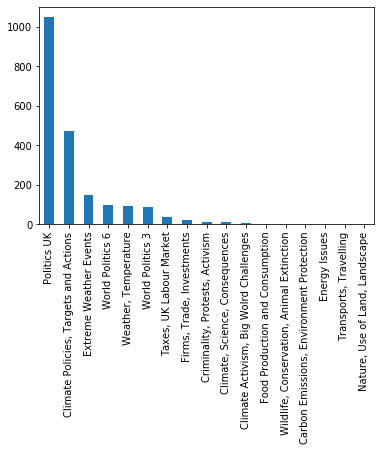

In [77]:
## There are some extreme values
# Articles in the last percentiles are too long and often just a summary of the day or so 
raw_check = raw.loc[raw['LenText']>=3500]
raw_check['Topic_Name'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [78]:
# It's ok to drop these extremes
df['LenText'] = df['Transcript'].str.split().str.len()
df = df[df.LenText<=3500]

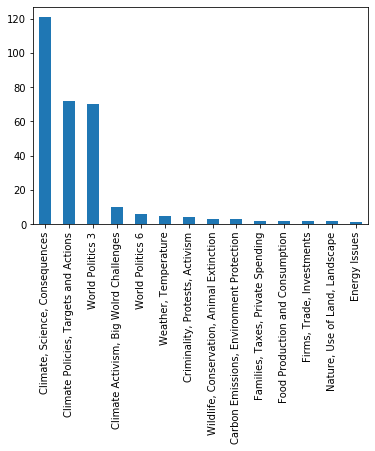

In [81]:
# And check too short ones (some letters to the editor, and other possible scraping mistakes)
raw_check = raw.loc[raw['LenText']<=30]
raw_check['Topic_Name'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [83]:
raw_check.head(10)

,Transcript,Topic_Name,LenText
716,You imply that there is an academic conspiracy...,World Politics 3,28
992,PUBLICATION-TYPE: Newspaper REGION: Nationa...,World Politics 3,9
1097,PUBLICATION-TYPE: Newspaper REGION: Nation...,World Politics 3,9
1150,PUBLICATION-TYPE: Newspaper REGION: Nationa...,World Politics 3,9
1631,There is no meteorological reason why global w...,"Climate, Science, Consequences",28
1700,"Moreover, wildlife experts now suggest that gl...","Climate, Science, Consequences",21
1792,"Is this due to metrication, because I don't th...","Climate, Science, Consequences",20
2848,This is what comes of decades of virtue-signal...,"Climate, Science, Consequences",26
2849,This is what comes of decades of virtue-signal...,"Climate, Science, Consequences",26
2923,GRAPHIC: Reflections: Rab Butler PUBLICATION-...,World Politics 3,13


In [84]:
# We arbitrarily get rid of articles with fewer than 20 words (it would be just a 2 lines article)
df = df[df.LenText>20]

In [85]:
### Split each article into sentences

# Getting s as pandas series which has split on full stop and space, and new sentence a new line
s = df["Transcript"].str.split('\. ').apply(pd.Series,1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Transcript' # needs a name to join

# There are blank or empty cell values after above process. Removing them
s.replace('', np.nan, inplace=True)
s.replace(' ',np.nan, inplace=True)
s.dropna(inplace=True)

# Join now
df_sent = df[['Transcript','Topic_Name','Document_No', 'Program Name']]
del df_sent['Transcript']
df_sent = df_sent.join(s)

In [86]:
# Repeat process for '?'
s = df_sent["Transcript"].str.split('\? ').apply(pd.Series,1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Transcript' # needs a name to join

# There are blank or empty cell values after above process. Removing them
s.replace('', np.nan, inplace=True)
s.replace(' ',np.nan, inplace=True)
s.dropna(inplace=True)

# Join now
df_sent2 = df[['Transcript','Topic_Name','Document_No', 'Program Name']]
del df_sent2['Transcript']
df_sent2 = df_sent2.join(s)

In [87]:
# Repeat process for '!'
s = df_sent2["Transcript"].str.split('\! ').apply(pd.Series,1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'Transcript' # needs a name to join

# There are blank or empty cell values after above process. Removing them
s.replace('', np.nan, inplace=True)
s.replace(' ',np.nan, inplace=True)
s.dropna(inplace=True)

# Join now
df_sent3 = df[['Transcript','Topic_Name','Document_No', 'Program Name']]
del df_sent3['Transcript']
df_sent3 = df_sent3.join(s)

In [88]:
### NOW WE GET RID OF TOO SHORT SENTENCES
df_sent3['LenText'] = df_sent3['Transcript'].str.split().str.len()

# These short sentences are meaningless. They don't matter anyway
df_sent3 = df_sent3[df_sent3['LenText']>3]

In [89]:
### NOW GET RID OF OTHER USELESS SENTENCES
# For various reasons there are sentences that we really don't want.
# EG if article is from an online version and random sentences that link to other articles appear
# Example: "Read more: Obama meets Italian president tomorrow in Rome"
# Sentences like these are totally disconnected from the article
# Let's drop them

df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Captions:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Related:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Rating:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Read:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("block-time")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Animation:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("·")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Click to enlarge:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("READ MORE:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Read more")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("In pictures:")]
df_sent3 = df_sent3[~df_sent3.Transcript.str.contains("Related articles")]


In [90]:
### GET RID OF MORE UNINFORMATIVE SENTENCES
# From Nexis, in some cases at the end of the scraped articles there's a bunch of text related to the article tags
# Example: "GEOGRAPHY: ITALY.  TOPIC: POLITICS (50%); ENERGY (82%); CINEMA (12%)"
# I want to get rid of them

# Function to detect number of upper cases characters in string
def share_upper(s):
    d={"UPPER_CASE":0, "LOWER_CASE":0}
    for c in s:
        if c.isupper():
           d["UPPER_CASE"]+=1
        elif c.islower():
           d["LOWER_CASE"]+=1   
        else:
           pass
    return d["UPPER_CASE"]/(d["UPPER_CASE"]+d["LOWER_CASE"])

# Function to detect number of letter characters in string
def letters(s):
    d={"UPPER_CASE":0, "LOWER_CASE":0}
    for c in s:
        if c.isupper():
           d["UPPER_CASE"]+=1
        elif c.islower():
           d["LOWER_CASE"]+=1   
        else:
           pass
    return d["UPPER_CASE"]+d["LOWER_CASE"]

# Create column with number of letters
df_sent3['letters'] = df_sent3['Transcript'].apply(lambda x:letters(x))

# Get rid of sentences with less than 20 letters (letters, not charachters! they are uninformative)
df_sent3 = df_sent3[df_sent3['letters']>20]

# Create column with share of upper case letters
df_sent3['share_upp'] = df_sent3['Transcript'].apply(lambda x:share_upper(x))

# Drop if this share is higher than 50% [after manual check it makes sense]
df_sent3 = df_sent3[df_sent3['share_upp']<=0.5]

In [91]:
### NOW GET RID OF DUPLICATE ARTICLES AND DUPLICATE SENTENCES WITHIN ARTICLES
# Start by getting rid of duplicate sentences within articles
df_sent3 = df_sent3.drop_duplicates(['Topic_Name','Document_No','Program Name', 'LenText','share_upp','letters'])

# Now get rid of duplicate articles
df_sent3 = df_sent3.drop_duplicates(['Topic_Name','Program Name','Transcript', 'LenText','share_upp','letters'])

# Difference: 'Program Name' is the article title, 'Transcript' is the text of the sentence, and 'Document_No'
# is a unique document identifier. Therefore:
# 1- I drop duplicates sentences (indeed 'Transcript' is not in the 'drop_duplicates' arguments) while keeping the rest equal
# 2- I drop duplicate articles (indeed 'Document_No' is not in the 'drop_duplicates' arguments) while keeping the rest equal

In [92]:
### NOW YOU SHOULD SAVE SO IT'S READY FOR RE-USE AND ANALYSIS ###
with open(dir+'data_sentences.pkl', 'wb') as f:
    pickle.dump(df_sent3,f)

### Get predictions
We can finally get the predicted labels for each sentence in this dataset.

In [93]:
## Import dataset
with open(dir+'data_sentences.pkl', 'rb') as f:
    db = pickle.load(f)

In [94]:
## BERT: Get The Vector Transformations from the Fine Tuned BERT
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])
    
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [95]:
# Now extracting the representations [this takes a REAL while]
db_emb = np.apply_along_axis(getPrediction, 0,np.array(db['Transcript']))

Each sentence in the original dataset is now converted to a 768-dimensional vector obtained from the fine-tuned BERT model. We can now get the predicted labels.

In [96]:
# Construct dataset for prediction
db_emb_final = []
for i in range(0,db_emb.shape[0]):
    db_emb_final = db_emb_final + [db_emb[i]]
    
df_pred = pd.DataFrame({'emb': db_emb_final})

# Save it for future use
with open(dir+'db_embreddings.pkl', 'wb') as f:
    pickle.dump(df_pred,f)
    
def pred_generator(df):
    x_list= df['emb'].to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
            yield x_train

In [98]:
## Use model to predict labels in expanded dataset
num_sequences_test = len(df_pred['emb'].to_list())
batch_size_val = 16
batches_per_epoch_pred = 120823
num_features = 768

In [99]:
# Get predictions
predictions = model.predict_generator(pred_generator(df_pred), steps = batches_per_epoch_pred)

# Create and store dataset
predicted = pd.DataFrame(np.argmax(predictions,axis=1), columns = ['predicted'])

with open(dir+'db_predictions2.pkl', 'wb') as f:
    pickle.dump(predicted,f)

In [100]:
# What does this dataset look like?
predicted.head(5)

,predicted
0,2
1,2
2,2
3,2
4,2


In [102]:
## Match these predictions to the original data
# Reset the index of the original dataset
db2 = db.reset_index(drop=True)

# Merge dataset with predictions
dball = pd.concat([db2,predicted], axis=1)

In [103]:
# What does this dataset look like?
dball.head(5)

,Topic_Name,Document_No,Program Name,Transcript,LenText,letters,share_upp,predicted
0,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,Wilcox's sentiments echo those of thousands of...,9,55,0.018182,2
1,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,"And in three weeks, UK plc's anger at the admi...",19,89,0.044944,2
2,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,The Treasury Select Committee is to probe how ...,14,77,0.064935,2
3,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,A series of fierce submissions to the committe...,38,179,0.033520,2
4,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,"The Institute of Directors, the Federation for...",34,186,0.059140,2


In [107]:
## Do some adjustments

# Rename columns
dball = dball.rename(columns={"Program Name": "Title", "LenText": "words"})

# Drop useless column
dball = dball.drop(['share_upp'], axis=1)

# New look
dball.head(5)

,Topic_Name,Document_No,Title,Transcript,words,letters,predicted
0,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,Wilcox's sentiments echo those of thousands of...,9,55,2
1,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,"And in three weeks, UK plc's anger at the admi...",19,89,2
2,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,The Treasury Select Committee is to probe how ...,14,77,2
3,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,A series of fierce submissions to the committe...,38,179,2
4,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,"The Institute of Directors, the Federation for...",34,186,2


In [108]:
### Add information about source and date

# Need original data with all articles
with open(dir+'all_articles_topic.pkl', 'rb') as f:
    articles = pickle.load(f)
    
articles.head(5)

,Source,Date,Program Name,Transcript,trans_pp,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Transcript2,Topic_Name,Topic_Map
0,The Sunday Telegraph (LONDON),"February 01, 2004, Sunday",Business blasts Brown on the burden of tax col...,Wilcox's sentiments echo those of thousands of...,wilcox sentiments echo thousands businessmen t...,0,6.0,0.2123,"tax, labour, year, rise, economy, price, pay, ...",Wilcox's sentiments echo those of thousands of...,"Taxes, UK Labour Market",14.0
1,The Sunday Telegraph (LONDON),"February 08, 2004, Sunday",In search of another global calamity,APOCALYPSES in Maggie Gee's fiction are of the...,apocalypses maggie gee fiction peg variety vog...,1,7.0,0.4143,"child, age, woman, also, family, include, year...",APOCALYPSES in Maggie Gee's fiction are of the...,Unclassified 8,8.0
2,The Sunday Telegraph (LONDON),"December 05, 2004, Sunday",All in the best possible taste (mostly) Whethe...,Nigella Lawson has made her name with the same...,nigella lawson made name kind gourmandist gust...,2,0.0,0.3062,"say, get, people, make, time, go, take, think,...",Nigella Lawson has made her name with the same...,Unclassified 1,1.0
3,The Sunday Telegraph (LONDON),"December 12, 2004, Sunday",Flooding: don't let our defences down Resident...,Residents also dispute the accuracy of the Env...,residents also dispute accuracy environment ag...,3,14.0,0.4409,"flood, water, say, people, area, home, storm, ...",Residents also dispute the accuracy of the Env...,Extreme Weather Events,10.0
4,The Sunday Telegraph (LONDON),"December 12, 2004, Sunday","Save the world, ignore global warming",Global warming will mainly harm the developing...,global warming mainly harm developing countrie...,4,22.0,0.2346,"would, may, even, many, claim, believe, make, ...",Global warming will mainly harm the developing...,World Politics 3,3.0


In [110]:
# Create sub-data to merge with necessary information (including topic keywords)
art_toMerge = articles[['Source','Date','Keywords','Document_No']]

# Create final dataset
dball2 = pd.merge(dball,art_toMerge, on='Document_No', how='left')

dball2.head(5)

,Topic_Name,Document_No,Title,Transcript,words,letters,predicted,Source,Date,Keywords
0,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,Wilcox's sentiments echo those of thousands of...,9,55,2,The Sunday Telegraph (LONDON),"February 01, 2004, Sunday","tax, labour, year, rise, economy, price, pay, ..."
1,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,"And in three weeks, UK plc's anger at the admi...",19,89,2,The Sunday Telegraph (LONDON),"February 01, 2004, Sunday","tax, labour, year, rise, economy, price, pay, ..."
2,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,The Treasury Select Committee is to probe how ...,14,77,2,The Sunday Telegraph (LONDON),"February 01, 2004, Sunday","tax, labour, year, rise, economy, price, pay, ..."
3,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,A series of fierce submissions to the committe...,38,179,2,The Sunday Telegraph (LONDON),"February 01, 2004, Sunday","tax, labour, year, rise, economy, price, pay, ..."
4,"Taxes, UK Labour Market",0,Business blasts Brown on the burden of tax col...,"The Institute of Directors, the Federation for...",34,186,2,The Sunday Telegraph (LONDON),"February 01, 2004, Sunday","tax, labour, year, rise, economy, price, pay, ..."


It would be useful now to check whether it actually worked or not. Let's sample few sentences that should be labelled as *skeptic* (we do the hard test immediately). If these are correctly classified, it's already a good sign and we can imagine that also classification of *environmental* and *unrepresentative* sentences also worked. Why? Because the *skeptic* ones were severely underrepresented in the training sample! Remember? There were roughly 500 *skeptic* sentences for taining, compared to over 4000 *environmental* and 6000 *unrepresentative*.

In [121]:
# This is an option in order for the string not to be truncated (so that we can read more of the output)
pd.options.display.max_colwidth = 100

# Sample the 'skeptic' sentences
negatives = dball2.loc[dball2['predicted']==0]

# Check if they are actually skeptic
negatives['Transcript'].head(10)

53     So action on global warming is basically a very costly way of doing very little for much richer ...
71     So in a curious way, global warming really is the moral test of our time, but not in the way its...
456                          "Global warming - at least the modern nightmare version - is a myth," he said
460                                            They say this is global warming: I say this is poppycock." 
472    "Even the idea of modelling climate change is mostly theoretical at the moment, so it is impossi...
522    Media reaction to both the original scientific paper and our short comment in Nature magazine il...
546                                                                     Mainstream science was unimpressed
680    For some reason, this isn't true in climatology - or at least, so those scientists working on gl...
723    A similar picture has emerged with icebergs, whose increasing numbers have been taken as proof t...
724    New research suggests that the

It looks like it worked! Recall that the model's accuracy is around $85\%$ therefore it's possible that some sentences will be wrongly classified. However this is already a very good result! As we can see the sentences above all seem to diplay some doubtful statements about climate science.

In [136]:
# Sample 'environmental' sentences
positives = dball2.loc[dball2['predicted']==1]
positives = positives.sample(n=10, random_state = 100)

# Check if they are actually in line with climate science
positives['Transcript'].head(10)

1931241    He warned his party against taking pleasure in the Lib Dems' collapse, saying voters have become...
1170595        "It's easy enough to start with the 100,000 internal flights: make the train network comparable
564615     Beaufort County Sheriff's LieutenantColonel Neil Baxley said that South Carolina county was prep...
726236     Unique landscapes Machair, a grassy coastal habitat found only in north-west Scotland and the we...
1644956    But we know there are challenges ahead in the face of climate change and threats from new, invas...
1751993    The Canadian leader said that despite Trump's pledge to pull the US out of the North American Fr...
1300745    The US hasn't regulated yet but federal policy is drifting in the wrong direction," said Logomasini
446254                       The world population was 5.47bn, of whom 77 per cent were in developing countries
1266889    Dorothy Thompson, chief executive of Drax, the biggest coal-fired power station in the UK, said ...
5

Well, I would have hoped for a better outcome. There seems to be some *uninformative* stuff in there as well, therefore some misclassification. The hope is that at the article level we can get a good representation (though with some noise) of the amount of pro-climate science or pro-skeptic views within newspapers. Don't forget to save your dataset for analysis!

In [137]:
# Export
with open(dir+"dbFinal.pkl", 'wb') as f:
    pickle.dump(dball2, f)